In [54]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [55]:
conn = sqlite3.connect("../db.sqlite3")

query = """
    SELECT restaurant_order.id as order_id, restaurant_order.datetime, restaurant_orderitem.quantity,
           restaurant_product.name, restaurant_product.price
    FROM restaurant_order
    JOIN restaurant_orderitem ON restaurant_order.id = restaurant_orderitem.order_id
    JOIN restaurant_product ON restaurant_orderitem.product_id = restaurant_product.id
"""

data = pd.read_sql(query, conn)
print(f"Shape: {data.shape}")
data.head(8)

Shape: (74818, 5)


,order_id,datetime,quantity,name,price
0,1,2019-08-03 20:25:00,2,Plain Papadum,0.80
1,1,2019-08-03 20:25:00,1,King Prawn Balti,12.95
2,1,2019-08-03 20:25:00,1,Garlic Naan,2.95
3,1,2019-08-03 20:25:00,1,Mushroom Rice,3.95
4,1,2019-08-03 20:25:00,1,Paneer Tikka Masala,8.95
5,1,2019-08-03 20:25:00,1,Mango Chutney,0.50
6,2,2019-08-03 20:17:00,1,Plain Naan,2.60
7,2,2019-08-03 20:17:00,1,Mushroom Rice,3.95


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   order_id  74818 non-null  int64  
 1   datetime  74818 non-null  object 
 2   quantity  74818 non-null  int64  
 3   name      74818 non-null  object 
 4   price     74818 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.9+ MB


In [57]:
data["datetime"] = pd.to_datetime(data["datetime"])
data["datetime"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 74818 entries, 0 to 74817
Series name: datetime
Non-Null Count  Dtype         
--------------  -----         
74818 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 584.6 KB


In [67]:
data.to_csv("../restaurant_data.csv")

# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

In [70]:
# write your code here
product_popularity = data.groupby("name")["quantity"].sum().sort_values(ascending=False)
top_10_products = product_popularity.head(10)
top_10_products

name
Plain Papadum           10648
Pilau Rice               6367
Plain Naan               4983
Garlic Naan              3318
Plain Rice               2964
Onion Bhajee             2749
Mango Chutney            2504
Chicken Tikka Masala     2473
Chapati                  1935
Mint Sauce               1840
Name: quantity, dtype: int64

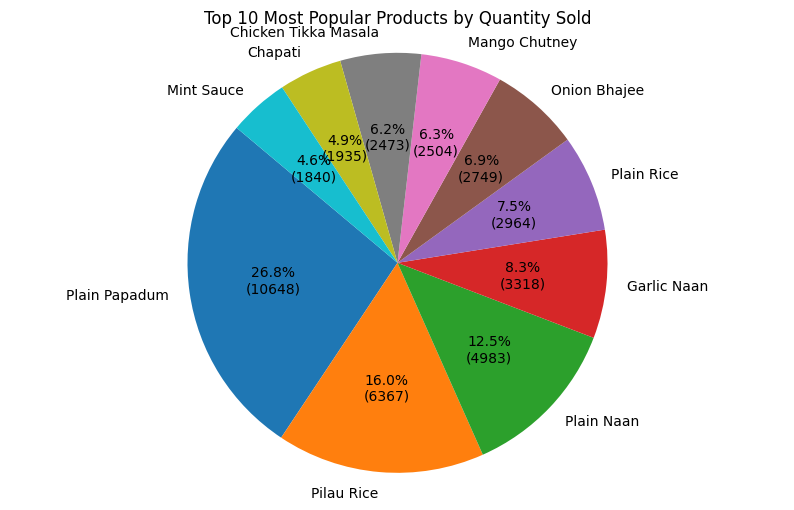

In [76]:
plt.figure(figsize=(10, 6))
plt.pie(
    top_10_products,
    labels=top_10_products.index,
    autopct=lambda p: "{:.1f}%\n({:.0f})".format(p, p * sum(top_10_products) / 100),
    startangle=140,
)
plt.title("Top 10 Most Popular Products by Quantity")
plt.axis("equal")
plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

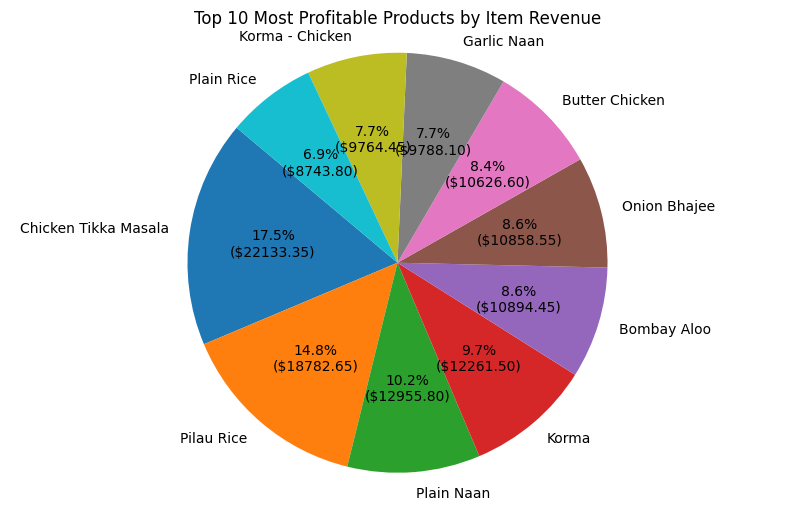

In [77]:
data["item_price"] = data["quantity"] * data["price"]

product_revenue = data.groupby("name")["item_price"].sum().sort_values(ascending=False)

top_10_revenue_products = product_revenue.head(10)

plt.figure(figsize=(10, 6))
plt.pie(
    top_10_revenue_products,
    labels=top_10_revenue_products.index,
    autopct=lambda p: "{:.1f}%\n(${:.2f})".format(
        p, p * sum(top_10_revenue_products) / 100
    ),
    startangle=140,
)
plt.title("Top 10 Most Profitable Products")
plt.axis("equal")
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

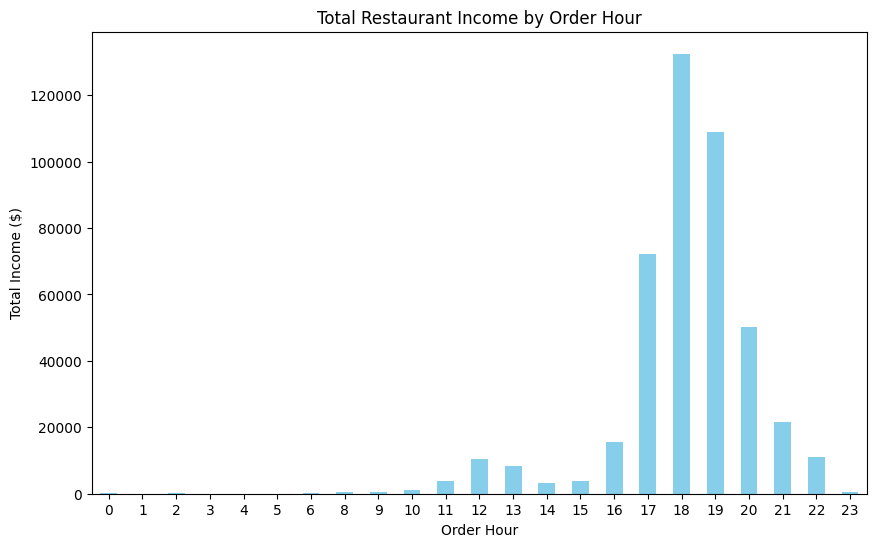

In [78]:
data["Order Hour"] = data["datetime"].dt.hour
hourly_income = data.groupby("Order Hour")["item_price"].sum()

plt.figure(figsize=(10, 6))
hourly_income.plot(kind="bar", color="skyblue")
plt.title("Total Restaurant Income by Order Hour")
plt.xlabel("Order Hour")
plt.ylabel("Total Income ($)")
plt.xticks(rotation=0)
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

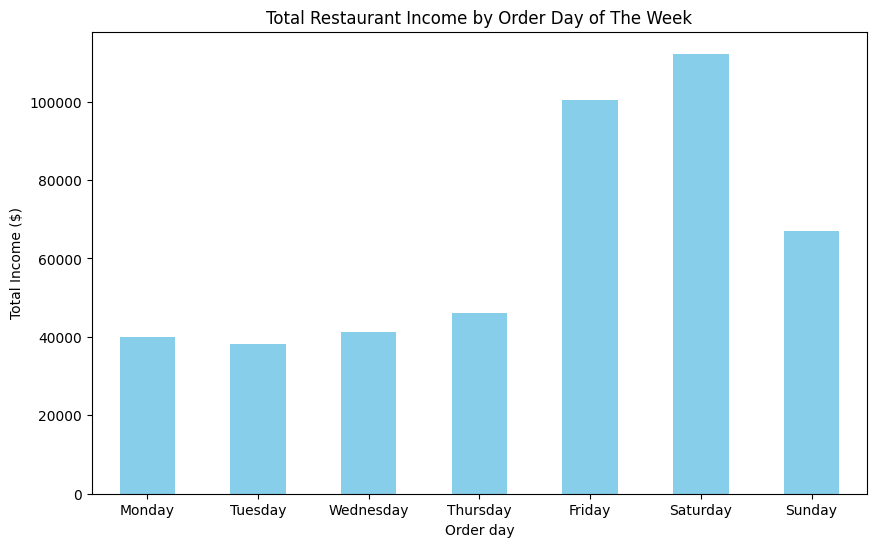

In [82]:
data["Order Day Of The Week"] = data["datetime"].dt.dayofweek

day_names = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}
data["Day Name"] = data["Order Day Of The Week"].map(day_names)

weekly_day_income = data.groupby("Day Name")["item_price"].sum()

desired_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

plt.figure(figsize=(10, 6))
weekly_day_income.loc[desired_order].plot(kind="bar", color="skyblue")
plt.title("Total Restaurant Income by Order Day of The Week")
plt.xlabel("Order day")
plt.ylabel("Total Income ($)")
plt.xticks(rotation=0)
plt.show()